<center><h1>Time series analysis</h1></center>
<center><h2>Tutorial 2: Forecasting</h2></center>
<br>

This tutorial we study the practical application of basic forecasting methods in Python. 

<a class="buttom" href=">#Data:-Australian-CPI-Inflation">Data: Australian CPI inflation</a> <br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#Random-Walk">Random Walk</a> <br>
<a class="buttom" href="#Simple-Exponential-Smoothing">Simple Exponential Smoothing</a> <br>
<a class="buttom" href="#Model-diagnostics">Model diagnostics</a> <br>
<a class="buttom" href="#Model-validation">Model validation</a> <br>
<a class="buttom" href="#Forecast">Forecast</a> <br>

Based in the work of Marcel Scharth http://www.marcelscharth.com/

This notebook relies on the following imports and settings.

In [6]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [7]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [8]:
plt.rcParams['figure.figsize'] = [15, 10]

## Data: Australian CPI inflation

Our data is the quarterly change in the Consumer Price Index (CPI) calculated by the Australian Bureau of Statistics. The original dataset is in the [ABS website](http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/6401.0Jun%202016?OpenDocument), where you can also find the [explanatory notes](http://www.abs.gov.au/AUSSTATS/abs@.nsf/Lookup/6401.0Explanatory%20Notes1Jun%202016?OpenDocument). We use the index for all expenditure groups, which according to the ABS documentation already contains seasonal adjustments for components that are subject to calendar effects.

We start by loading the data and converting the index to quarterly periods (note that we have to specify this frequency when converting the index). We focus on the data since 1980, which has a total of 146 observations.  

In [11]:
data=pd.read_csv('datasets/inflation.csv', index_col='Date', parse_dates=True, dayfirst=True)
data.index=data.index.to_period(freq='Q') # converting the index to quarterly period instead of dates
data=data['1980':] # filtering the use data from Jan/1980 onwards
data.head()

,Inflation
Date,
1980Q1,2.0
1980Q2,3.1
1980Q3,1.5
1980Q4,2.3
1981Q1,2.2


For univariate time series modelling, it is better to work with a pandas series rather than dataframe. 

In [13]:
y=data['Inflation']

## Exploratory data analysis

The first step in our analysis is a time series plot. We can see that both the level and volatility of inflation is much lower in recent times than it was in the 80s. There is a noticeable outlier in the third quarter of 2000 due to introduction of the GST in Australia. 

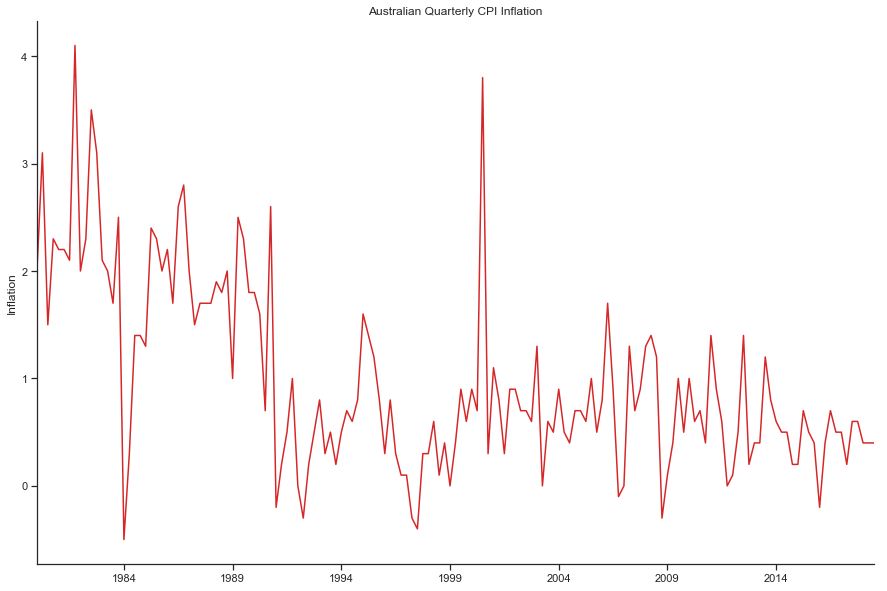

In [6]:
fig, ax= plt.subplots();#figsize=(9,6))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

In [7]:
y.describe().round(2)

count    155.00
mean       0.99
std        0.87
min       -0.50
25%        0.40
50%        0.70
75%        1.50
max        4.10
Name: Inflation, dtype: float64

## Random walk

In this section we use the random walk method to illustrate the process that we will follow to generate forecasts in the tutorials. 

1. Specify the forecast horizon.

2. Create a range of dates or periods starting from the time index following the last observation in the data. 

3. Generate the forecasts and store them in a series indexed by step 2. 

Below, we generate point forecasts for one to four quarters after the end of the series. 

In [23]:
h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

2018Q4    0.4
2019Q1    0.4
2019Q2    0.4
2019Q3    0.4
Freq: Q-DEC, dtype: float64

To compute interval forecasts, we first estimate the standard deviation of the errors.

In [29]:
resid=y-y.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

0.785

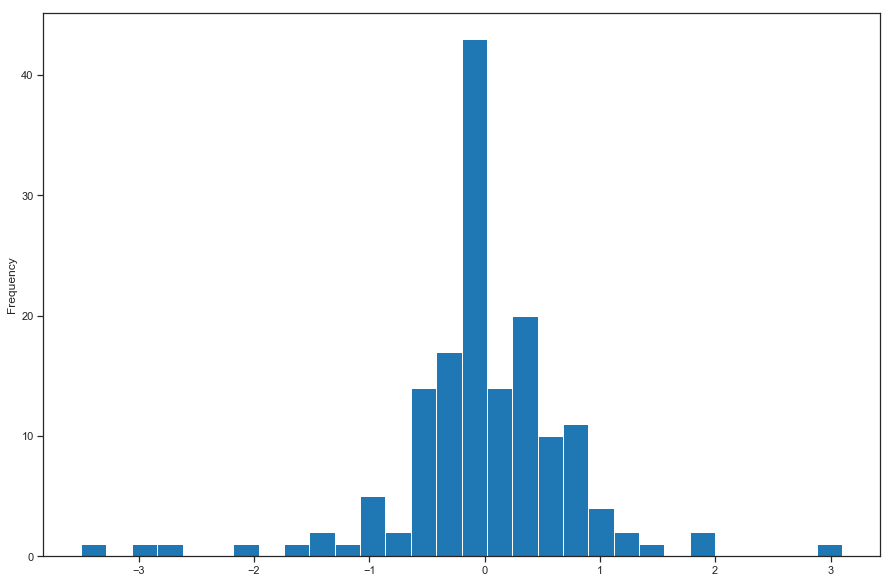

In [31]:
resid.plot.hist(bins=30);

Using the formulas from the lecture, the interval forecasts are as below. 

In [32]:
np.arange(1,h+1)

array([1, 2, 3, 4])

In [33]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2018Q4,-1.138,1.938
2019Q1,-1.775,2.575
2019Q2,-2.264,3.064
2019Q3,-2.676,3.476


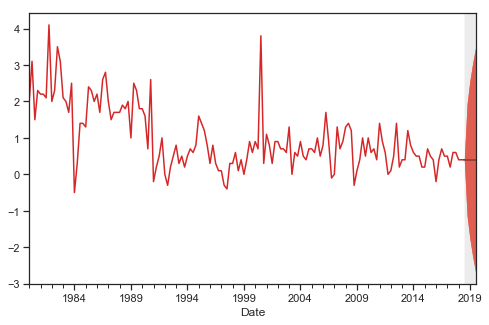

In [34]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(y['1980':],point_pred,intv,intv,intv)

plt.show()

## Simple exponential smoothing

The exponential smoothing functions are available since version 0.9 of statsmodels in the **tsa.
holtwinters** module. Take a look in the official [docs](https://www.statsmodels.org/stable/tsa.html#exponential-smoothing). Also, they are improving them, so follow the news for the next release.

In [15]:
model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
fitted_ses = model_ses.fittedvalues
model_ses.summary()

Dep. Variable:,endog,No. Observations:,155
Model:,SimpleExpSmoothing,SSE,63.508
Optimized:,True,AIC,-134.300
Trend:,None,BIC,-128.213
Seasonal:,None,AICC,-134.033
Seasonal Periods:,None,Date:,"Fri, 06 Sep 2019"
Box-Cox:,False,Time:,16:27:50
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2828353,alpha,True
initial_level,2.2914789,l.0,True


Also AIC and BIC looks off so we are continue our analysis with MSE.

In [16]:
mse_ses = sm.tools.eval_measures.mse(y,fitted_ses)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))

 In-sample fit:
 MSE               0.410


You can calculate AIC and BIC as follows

In [17]:
N = len(y)
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -150.786
 AIC               307.571
 BIC               316.701


Now, let's see how the smoothed data fits the original data

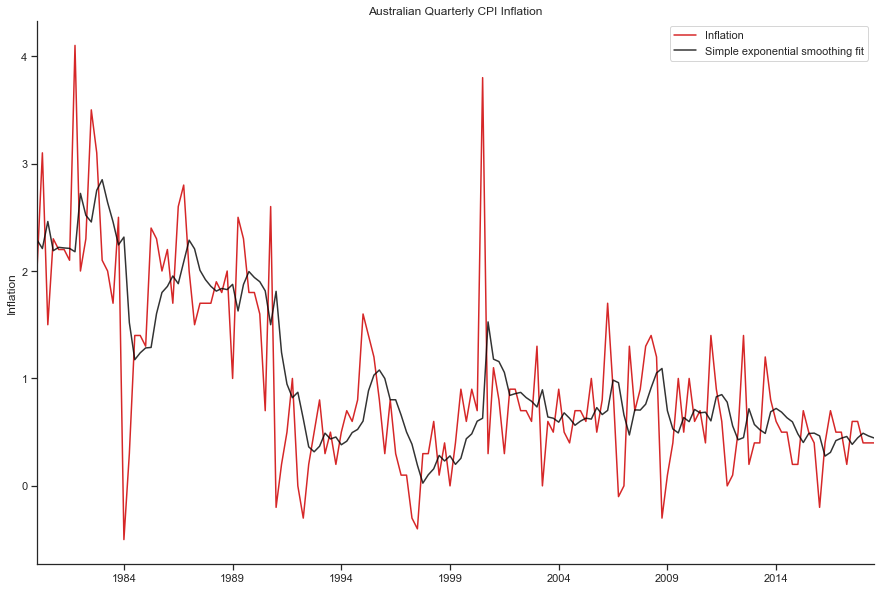

In [18]:
fig, ax= plt.subplots();#figsize=(9,6))
y.plot(color=red, label='Inflation')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Model diagnostics

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.

We compute the residuals as follows.

In [19]:
resid=y-fitted_ses # model_ses.resid isn't a panda.Series, so no index, no plot

The following cells compute the diagnostics. We find that the residuals are uncorrelated, have non-constant variance (due to higher volatitility in the 80s), and are non-Gaussian. 

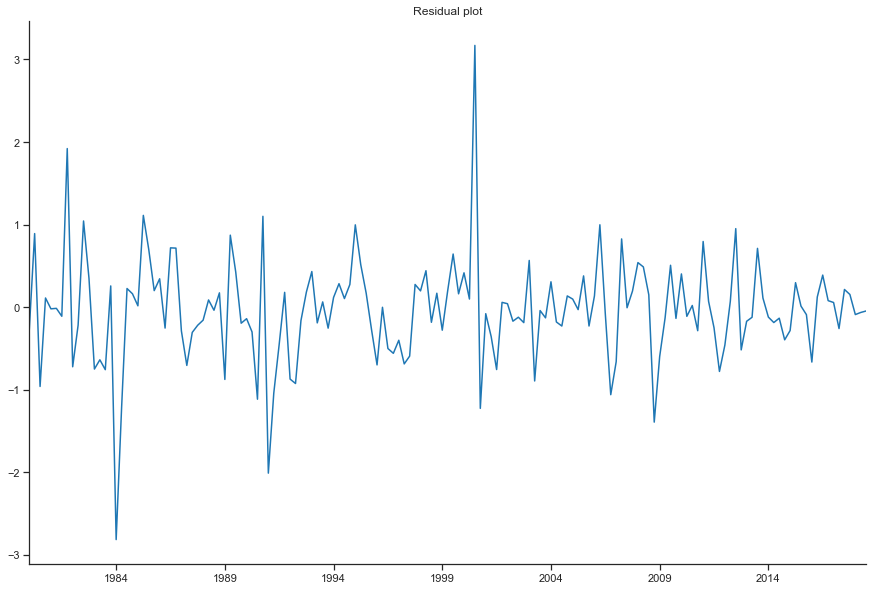

In [20]:
fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

Next is the residual ACF plot aka correlogram

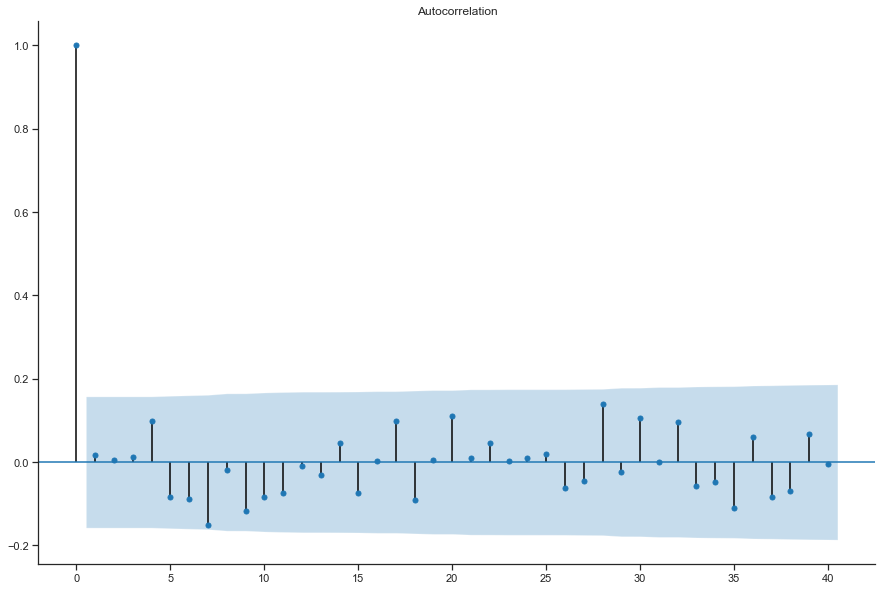

In [21]:
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

Plotting histogram (in blue) and kernel density estimation (in black) for the residuals

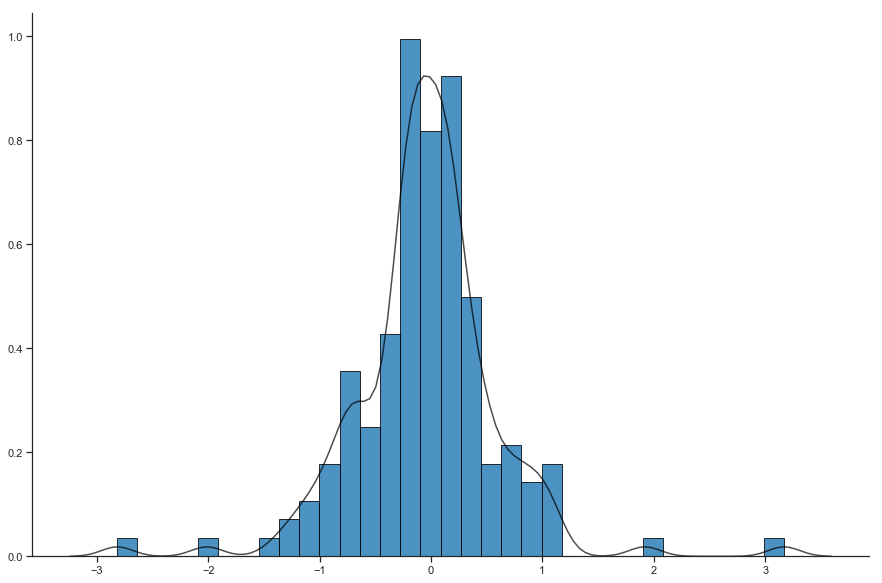

In [22]:
def hist(series):
    fig, ax= plt.subplots();#figsize=(9,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

## Model validation

We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods. 

In [38]:
(y.index.get_loc('2004Q1')-1)/len(y)

0.6129032258064516

In [35]:
# Real time forecasting - use it as a template - expanding window

validation=y['2004Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2004Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

,RW,SES,Actual
Date,,,
2017Q3,0.2,0.386171,0.6
2017Q4,0.6,0.446716,0.6
2018Q1,0.6,0.490131,0.4
2018Q2,0.4,0.464593,0.4
2018Q3,0.4,0.446321,0.4


We find that simple exponential smoothing generates more accurate forecasts. 

In [24]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,0.518,0.068
SES,0.446,0.059


## Forecast

We show how to do expanding and rolling point forecast. 

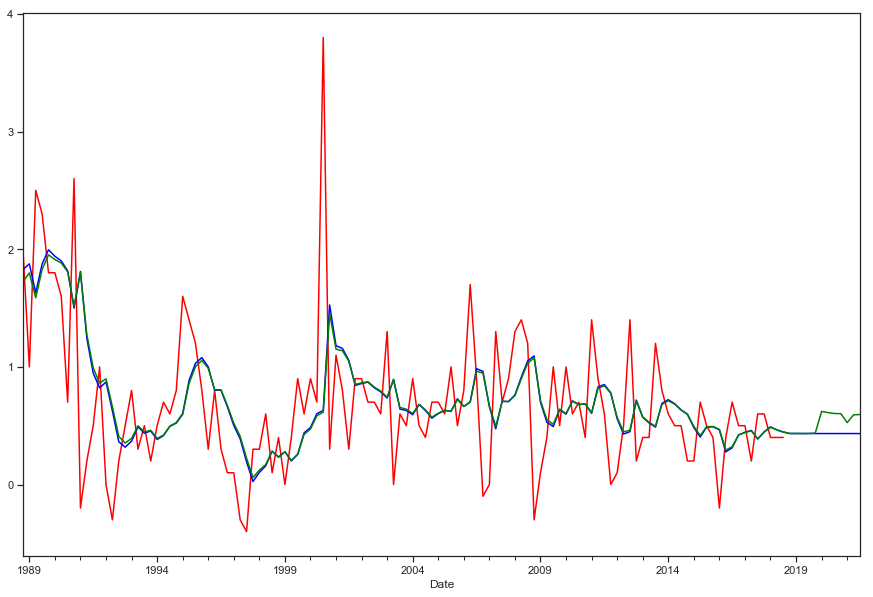

In [27]:
h=12
w=h*10
data = y
model = sm.tsa.SimpleExpSmoothing
pred_index = y.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');

In this case, **statsmodels** doesn't provide interval forecast